In [1]:

import numpy as np
import pandas as pd
from collections import deque
import torch
from tqdm import trange
import argparse
import glob
from utils import save, collect_random
import random
from agent import IQL
from torch.utils.data import DataLoader, TensorDataset
from buffer import ReplayBuffer
from sklearn import preprocessing
from utils import TOTAL_DICT
from cityhash import CityHash64


In [2]:

feature_names='acc_first_purchase_price_usd,acc_total_charge_sum_usd,acc_total_refund_sum_usd,role_first_purchase_price_usd,role_last_purchase_price_usd,acc_role_cnt,acc_total_charge_cnt,acc_total_refund_cnt,role_total_charge_cnt,role_total_refund_cnt,bundle_pop_buy_count_last_day,bundle_pop_buy_count_last_day_campaign_stage_trigger,bundle_pop_buy_count_last_day_tech_unlock_trigger,bundle_pop_buy_count_last_week,bundle_pop_buy_count_last_week_adjust,bundle_pop_count_campaign_stage_trigger_9999,bundle_pop_count_last_day,bundle_pop_count_last_day_campaign_stage_trigger,bundle_pop_count_last_day_tech_unlock_trigger,bundle_pop_count_last_week,bundle_pop_count_last_week_adjust,bundle_pop_count_tech_unlock_trigger_9999,bundle_pop_buy_max_last_day,bundle_pop_buy_max_last_week,bundle_pop_buy_max_last_week_adjust,bundle_pop_buy_max_price_campaign_stage_trigger,bundle_pop_buy_max_price_campaign_stage_trigger_commax,bundle_pop_buy_max_price_tech_unlock_trigger,bundle_pop_buy_max_price_tech_unlock_trigger_commax,purchase_price_max,purchase_price_max_last_3days,purchase_price_max_last_day,purchase_price_max_last_month,purchase_price_max_last_week,purchase_price_max_last_week_adjust,bundle_pop_buy_sum_last_day,bundle_pop_buy_sum_last_week,bundle_pop_buy_sum_last_week_adjust,purchase_price_1499_last_week,purchase_price_1499_last_week_adjust,purchase_price_1999_last_week,purchase_price_1999_last_week_adjust,purchase_price_2999_last_week,purchase_price_2999_last_week_adjust,purchase_price_4999_last_week,purchase_price_4999_last_week_adjust,purchase_price_499_last_week,purchase_price_499_last_week_adjust,purchase_price_9999_last_week,purchase_price_9999_last_week_adjust,purchase_price_999_last_week,purchase_price_999_last_week_adjust,purchase_price_sum_last_3days,purchase_price_sum_last_day,purchase_price_sum_last_month,purchase_price_sum_last_week,purchase_price_sum_last_week_adjust,role_total_charge_sum_usd,role_total_refund_sum_usd,money_flow_in_cout_last_day,money_flow_in_cout_last_week,money_flow_in_cout_last_week_adjust,money_flow_out_cout_last_day,money_flow_out_cout_last_week,money_flow_out_cout_last_week_adjust,level,max_role_level,role_last_login_duration,role_lifespan,role_login_last_now,role_login_secondlast_last,role_login_secondlast_now,role_logout_last_now,role_no,role_purchase_first_last,role_purchase_first_now,role_purchase_last_now,vip_level,purchase_price_sum_max_ratio,purchase_price_sum_max_ratio_com2,role_create_os_android,role_create_os_ios,if_accounts_first_role,if_pruchase_active_in_1day,if_pruchase_active_in_30day,if_pruchase_active_in_3day,if_pruchase_active_in_7day,is_acc_transfer_from_old,is_acc_transfer_to_new,is_role_transfer_from_old,is_role_transfer_to_new,is_valid,role_type_fraud,role_type_no_install_info,resource_rarity,speedup_rarity,top_key_rarity,officer_bar_ticket_rarity,common_equipment_exp_consume_levelup_1_diff_num_relatively,common_equipment_exp_consume_blueprint_1_diff_num_relatively,common_equipment_exp_rarity,airforce_equipment_exp_consume_levelup_1_diff_num_relatively,airforce_equipment_exp_consume_blueprint_1_diff_num_relatively,airforce_equipment_exp_rarity,ammunition_consume_levelup_1_diff_num_relatively,ammunition_consume_levelup_10_diff_num_relatively,ammunition_consume_blueprint_1_diff_num_relatively,ammunition_consume_blueprint_10_diff_num_relatively,ammunition_rarity,airforce_ammunition_consume_levelup_1_diff_num_relatively,airforce_ammunition_consume_levelup_10_diff_num_relatively,airforce_ammunition_consume_blueprint_1_diff_num_relatively,airforce_ammunition_consume_blueprint_10_diff_num_relatively,airforce_ammunition_rarity,elements_consume_blueprint_1_diff_num_relatively,elements_consume_blueprint_10_diff_num_relatively,elements_consume_reform_diff_num_relatively,elements_rarity,airforce_elements_consume_blueprint_1_diff_num_relatively,airforce_elements_consume_blueprint_10_diff_num_relatively,airforce_elements_consume_reform_diff_num_relatively,airforce_elements_rarity,replacement_wrench_consume_mechanic_1_diff_num_relatively,replacement_wrench_rarity,officer_exp_consume_lvlup_1_diff_num_relatively,officer_exp_rarity,component_consume_diff_num_relatively,chest_choice_replacement_rarity,buy_rate_last_day,buy_rate_last_day_campaign_stage_trigger,buy_rate_last_day_tech_unlock_trigger,buy_rate_last_week,diamond_remain_usd,diamond_remain_rmb,svr_region,trigger_type,language,last1bundle,last2bundle,last3bundle,last4bundle,last5bundle'
feature_names=feature_names.split(',')
MAX_HASH_SIZE=10000
MAX_HASH_SIZE2=100000
FEATURE_MASK = (1 << 48) - 1


class dataset_iql:
    def __init__(self,data=None):
        # self.client=SQLClient('mixx')
        self.users=None
        # self.term_date=term_date
        
        self.used_data={}
        self.data=data
        self.next_ind=None
        popcol=['open_id','user_id','role_id','acc_id','serverid','bundle_type','event_time','svr_region','bundle_pop_buy_count_last_day_campaign_stage_trigger','dt','role_type','actions','reward','is_acc_transfer_to_new']
        # popcol=['open_id','user_id','serverid','bundle_type','event_time','svr_region','dt','actions','reward']
#         stdscaler=preprocessing.StandardScaler()
#         for i in self.data.columns:
#             if i not in popcol:
#                 self.data[i]=stdscaler.fit_transform(self.data[[i]])
        self.needcol=self.data.columns.drop(popcol)
        self.boxcox_vocab = dict()
        self.logbucket_vocab = dict()


    def get_vocab(self):
        for f in TOTAL_DICT['com_fea_num']:
            array = self.data[f]
            array = array.to_numpy()
            c = array.min()
            
            c = abs(c) + 2
            minv, maxv = array.min() + c, array.max() + c
            self.boxcox_vocab[f] = (2.0,c)
            self.logbucket_vocab[f] = np.exp(np.log(maxv)/40)
        
    def parse_feature_string(self,s,featue_col=None):
        
        
        pairs = filter(None, s.split('\x02'))

        # Further split each pair by the unit separator and create a dictionary
        if featue_col is None:
            parsed = dict(pair.split('\x03') for pair in pairs)
            return parsed

        parsed = {key: value for key, value in (pair.split('\x03') for pair in pairs) if key in featue_col}
        return parsed
        


    def dataloader(self,batch_size=1,reward_log=False):
        self.get_vocab()
        c = torch.tensor([self.boxcox_vocab[i][1] for i in TOTAL_DICT['com_fea_num']], dtype=torch.float32)
        b = torch.tensor([self.logbucket_vocab[i] for i in TOTAL_DICT['com_fea_num']], dtype=torch.float32)
       
        self.used_data['bol']=torch.tensor(self.data[TOTAL_DICT['com_fea_bool']].values)
        self.used_data['id']=torch.tensor(self.data[['et','id']].values, dtype=torch.int64)
        self.used_data['bundle']=torch.tensor(self.data[['last1bundle','last2bundle','last3bundle','last4bundle','last5bundle','content']].values, dtype=torch.int64)
        self.used_data['dis']=torch.tensor(self.data[['his30maxpay','his30minpay']].values).int()
        self.used_data['dis2']=torch.tensor(self.data['bundle_type'].values).int()
        self.used_data['dis3']=torch.tensor(self.data['intervene'].values).int()
        self.used_data['rat']=torch.tensor(self.data[TOTAL_DICT['com_fea_ratio']].values).unsqueeze(-1).float() #unsqueeze
        self.used_data['rat2']=(torch.tensor(self.data[TOTAL_DICT['com_fea_ratio']].values).float()*20).clamp(0,19).long()
        self.used_data['num']=torch.tensor(self.data[TOTAL_DICT['com_fea_num']].values).unsqueeze(-1).float()
        self.used_data['num2']=(torch.log(torch.tensor(self.data[TOTAL_DICT['com_fea_num']].values).float()+c)/ torch.log(b)).clamp(0, 39).long() 

        self.used_data['bol_next']=torch.tensor(self.data.loc[self.next_ind][TOTAL_DICT['com_fea_bool']].values)
        self.used_data['id_next']=torch.tensor(self.data.loc[self.next_ind][['et','id']].values, dtype=torch.int64)
        self.used_data['bundle_next']=torch.tensor(self.data.loc[self.next_ind][['last1bundle','last2bundle','last3bundle','last4bundle','last5bundle','content']].values, dtype=torch.int64)
        
        
        self.used_data['dis_next']=torch.tensor(self.data.loc[self.next_ind][['his30maxpay','his30minpay']].values, dtype=torch.int64)
        self.used_data['dis2_next']=torch.tensor(self.data.loc[self.next_ind]['bundle_type'].values, dtype=torch.int64)
        self.used_data['dis3_next']=torch.tensor(self.data.loc[self.next_ind]['intervene'].values).int()
        self.used_data['rat_next']=torch.tensor(self.data.loc[self.next_ind][TOTAL_DICT['com_fea_ratio']].values).unsqueeze(-1).float() #unsqueeze
        self.used_data['rat2_next']=(torch.tensor(self.data.loc[self.next_ind][TOTAL_DICT['com_fea_ratio']].values).float()*20).clamp(0,19).long()
        self.used_data['num_next']=torch.tensor(self.data.loc[self.next_ind][TOTAL_DICT['com_fea_num']].values).unsqueeze(-1).float()#unsq
        self.used_data['num2_next']=(torch.log(torch.tensor(self.data.loc[self.next_ind][TOTAL_DICT['com_fea_num']].values).float()+c)/ torch.log(b)).clamp(0, 39).long() 
       
        self.used_data['action']=torch.tensor(self.data['actions'].values).int()
        if reward_log:
            self.used_data['reward']=torch.log(torch.tensor(self.data['reward'].values))
        else:
            self.used_data['reward']=torch.tensor(self.data['reward'].values)
            # print(self.used_data[k].shape)
       
        
        tensordata = TensorDataset(self.used_data["bol"].int(),
                                   self.used_data["id"],
                                   self.used_data['bundle'],
                                   self.used_data["dis"],
                                   self.used_data["dis2"].unsqueeze(1),
                                   self.used_data['dis3'].unsqueeze(1),
                                   self.used_data["rat"],
                                   self.used_data["rat2"],
                                   self.used_data["num"],
                                   self.used_data["num2"],
                                   self.used_data["bol_next"].int(),
                                   self.used_data["id_next"],
                                   self.used_data['bundle_next'],
                                   self.used_data["dis_next"],
                                   self.used_data["dis2_next"].unsqueeze(1),
                                   self.used_data['dis3_next'].unsqueeze(1),
                                   self.used_data["rat_next"],
                                   self.used_data["rat2_next"],
                                   self.used_data["num_next"],
                                   self.used_data["num2_next"],
                                self.used_data["action"].unsqueeze(1),
                                self.used_data["reward"].unsqueeze(1).float())
                            
        dataloader  = DataLoader(tensordata, batch_size=batch_size, shuffle=True)
        
        return dataloader
    def get_next_obv_ind(self):
        tmp=self.data[['user_id','open_id']].reset_index()
        tmp2=tmp.shift(1).rename(columns={'user_id':'u2','open_id':'o2','index':'ind'})
     
        tmp=pd.concat([tmp,tmp2],axis=1)
        self.next_ind=tmp.apply(lambda x: x['ind'] if x['user_id']==x['u2'] and x['open_id']==x['o2'] else x['index'], axis=1)
        
        return self.next_ind
        
            


In [3]:
prc=pd.read_csv('/home/jovyan/cnn/new_dt/new_prc.csv')
# prc=pd.read_csv('/home/jovyan/ruokaigu/datas/resprice_data.csv')

/tmp/ipykernel_261/46722033.py:1: DtypeWarning: Columns (90) have mixed types. Specify dtype option on import or set low_memory=False.
  prc=pd.read_csv('/home/jovyan/cnn/new_dt/new_prc.csv')


In [4]:
prc=prc[prc['open_id']!='open_id']
prc=prc.fillna(0)
prc['last5bundle']=prc['last5bundle'].replace(0,'')
prc['last4bundle']=prc['last4bundle'].replace(0,'')
prc['last3bundle']=prc['last3bundle'].replace(0,'')
prc['last2bundle']=prc['last2bundle'].replace(0,'')
prc['last1bundle']=prc['last1bundle'].replace(0,'')
plist=[0,99,299,499,999,1499,1999,2999,4999,9999]
plist1=[99,299,499,999,1499,1999,2999,4999,9999]
inter=['price', 'gift_contents', 'not_intervened']
idict=dict((inter[i],i) for i in range(len(inter)))
pdict=dict((plist[i],i) for i in range(len(plist)))
pdict1=dict((plist1[i],i) for i in range(len(plist1)))

prc['reward']=prc.apply(lambda x: x['bundle_price']*x['actions'],axis=1)
prc['actions']=prc['bundle_price'].apply(lambda x: pdict1[x])
prc['his30maxpay']=prc['his30maxpay'].apply(lambda x: pdict[x])
prc['his30minpay']=prc['his30minpay'].apply(lambda x: pdict[x])
prc['intervene']=prc['intervene'].apply(lambda x: idict[x])
prc.drop(columns='bundle_price',inplace=True)
arr=['action_trigger', 'building_trigger-10029',
       'advancecard_unlock_trigger_air_force', 'tech_lv_trigger',
       'building_trigger-10028', 'mechanician_trigger',
       'teleport_trigger', 'tech_unlock_trigger',
       'campaign_stage_trigger', 'building_trigger-10001',
       'all_officer_lv_trigger', 'building_trigger-10024',
       'building_trigger-10027', 'gacha_tactic_up_trigger',
       'card_unlock_trigger', 'blackmall_trigger',
       'building_trigger-10004', 'building_trigger-10030',
       'population_consume_trigger', 'building_trigger-10005',
       'advancecard_unlock_trigger_ground_force',
       'blueprint_max_trigger_ground_force', 'multi_tech_lv_trigger',
       'action_trigger_miss', 'building_trigger-10015',
       'building_trigger-10012', 'gacha_tactic_trigger',
       'building_trigger-10014', 'blueprint_max_trigger_air_force',
       'building_trigger-10011', 'building_trigger-10003',
       'building_trigger-10006', 'building_trigger-10010',
       'building_trigger-10002', 'replacement_trigger',
       'officer_lv_trigger', 'building_trigger-10013',
       'building_trigger-10018', 'gacha_times_trigger', 'drawing_trigger',
       'unlock_slot_trigger', 'replacement_recycle_trigger',
       'gvg_trigger', 'battleroad_victory', 'battleroad_fail']
buntype=dict((arr[i],i) for i in range(len(arr)))
prc['bundle_type']=prc['bundle_type'].apply(lambda x:buntype[x])
prc['et']=prc.apply(lambda x :(CityHash64(x['event_time']+x['dt']) & FEATURE_MASK) % MAX_HASH_SIZE,axis=1)
prc['id']=prc.apply(lambda x :(CityHash64(x['open_id']+str(x['user_id'])+x['serverid']) & FEATURE_MASK) % MAX_HASH_SIZE,axis=1)
prc['last1bundle']=prc['last1bundle'].apply(lambda x :(CityHash64(x) & FEATURE_MASK) % MAX_HASH_SIZE2)
prc['last2bundle']=prc['last2bundle'].apply(lambda x :(CityHash64(x) & FEATURE_MASK) % MAX_HASH_SIZE2)
prc['last3bundle']=prc['last3bundle'].apply(lambda x :(CityHash64(x) & FEATURE_MASK) % MAX_HASH_SIZE2)
prc['last4bundle']=prc['last4bundle'].apply(lambda x :(CityHash64(x) & FEATURE_MASK) % MAX_HASH_SIZE2)
prc['last5bundle']=prc['last5bundle'].apply(lambda x :(CityHash64(x) & FEATURE_MASK) % MAX_HASH_SIZE2)

prc['content']=prc['content'].apply(lambda x :(CityHash64(x) & FEATURE_MASK) % MAX_HASH_SIZE2)


prc=prc.fillna(0)
real_reward=np.array(prc['reward'])
prc['reward']=np.log(prc['reward']+1)

In [5]:
train_data=prc[:int(0.7*prc.shape[0])]
eval_data=prc[int(0.7*prc.shape[0]):int(0.8*prc.shape[0])]
test_data=prc[int(0.8*prc.shape[0]):]

In [6]:

BATCH_SIZE=256
dts=dataset_iql(train_data)

ip=dts.get_next_obv_ind()
dtl=dts.dataloader()

dts_eval=dataset_iql(eval_data)

ip_eval=dts_eval.get_next_obv_ind()
dtl_eval=dts_eval.dataloader(BATCH_SIZE)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device=torch.device('cpu')

    
agent = IQL(state_size=2688,
                action_size=9,
                device=device,
           batch_size=BATCH_SIZE)

cuda:0


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import numpy as np
plist1=np.array([99,299,499,999,1499,1999,2999,4999,9999])

def get_reward(action,act_action,act_reward):
    action=action.astype(int)
    
    total=len(action)

    reward_total=np.where(act_reward>0,1,0)
    no_reward=np.where(act_reward<=0,1,0)
    same=np.where(action==act_action,1,0)
    lar=np.where(action>act_action,1,0)
    sma=np.where(action<act_action,1,0)
    reward_sum=reward_total.sum()
    reward_fail=total-reward_sum
    

    print("reward_total: ","%.4f"%(reward_total.sum()/total),"fail_action: ","%.4f"%(no_reward.sum()/total),\
          "same_reward: ","%.4f"%(np.sum(reward_total*same)/reward_sum),"reward_less: ","%.4f"%(np.sum(reward_total*sma)/reward_sum),"reward_lar: ","%.4f"%(np.sum(reward_total*lar)/reward_sum),\
          "possi_lar: ","%.4f"%(np.sum(lar*no_reward)/reward_fail),"possi_small: ","%.4f"%(np.sum(sma*no_reward)/reward_fail),"same_fail ","%.4f"%(np.sum(same*no_reward)/reward_fail))
    # # prices = np.array(plist)[action.astype(int)]
    # # action+=1
    # # act_action+=1
   
    # # tmp=action/act_action
    # # tmp2=np.where(tmp!=1,0,act_reward)
    # # tmp=np.where(tmp>1,0,tmp)
    # # tmp=np.where(tmp<1,0.1*prices,tmp*act_reward)
    # return tmp.sum(),tmp2.sum(),reward_total_num
    
    
def mse(action,act_action):
    print((sum(np.square(act_action-action)))**0.5)
    # return sum(np.square(act_action-action))**0.5
    
def quantile_reward(action,act_action,act_reward,reward_log=False):
    import matplotlib.pyplot as plt
    stats=np.array([0.0,
     0.0003787400580734756,
     0.0439829119535721,
     0.14246775790092817,
     0.00800099237114681,
     0.08088155128105287,
     0.07467597208374875,
     0.12568565043678473,
     0.221271054964539])
    quantile=[0,0.05,0.1,0.2]
    plist1=np.array([99,299,499,999,1499,1999,2999,4999,9999])
    if reward_log:
        plist1=np.array([np.log(i) for i in plist1])
    action=action.astype(int)
    length=len(action)
    

    reward_total=np.cumsum(np.where(action==act_action,act_reward,0))
    possi_reward=np.cumsum(np.where((action<act_action)&(act_reward<=0),plist1[action]*stats[action],0))
    possi_reward_large=np.cumsum(np.where((action>act_action)&(act_reward>0),plist1[action]*stats[action],0))
    res={}
    for i in quantile:
        result=reward_total+possi_reward*i+possi_reward_large*i
        res['quant_%2f'%i]=result.sum()
        
        plt.plot(result,label='quant=%2f'%i)
    plt.xlabel('dt')
    plt.ylabel('reward')
    plt.legend()
    plt.show()
    print(res)
        
        

def eval(dtl,agent,device):  
    tmp=np.array([])
    act_act=np.array([])
    act_reward=np.array([])
    
    for j in dtl:
       
        bol,rat,rat2,num,num2,ids,dis1,dis2,dis3,bun,actions,rewards=j[0].to(device),j[6].to(device),j[7].to(device),j[8].to(device),j[9].to(device),j[1].to(device),j[3].to(device),j[4].to(device),j[5].to(device),j[2].to(device),j[-2],j[-1]
#         bol,ids,dis1,dis2,rat,rat2,num,num2,bol_next,id_next,dis1_next,dis2_next,rat_next,rat2_next,num_next,num2_next, actions,rewards=j
        try:
      
            pre_act=agent.get_action(bol,rat,rat2,num,num2,ids,dis1,dis2,dis3,bun,True)
            tmp=np.append(tmp,pre_act)
            act_act=np.append(act_act,np.array(actions))
            act_reward=np.append(act_reward,rewards)
        except:
            break
    quantile_reward(tmp,act_act,act_reward)
    
    return mse(tmp,act_act),get_reward(tmp,act_act,act_reward)

def train(buffer,agent,dtl,dtl_eval,exploit=0.1):
        cnt=0
    
      
        for i in range(0, 15):
        
            for j in dtl:
                cnt+=1
                
                if cnt<BATCH_SIZE:
                    buffer.add(j)
                    continue
                if np.random.uniform()<exploit:
                    bol,rat,rat2,num,num2,ids,dis,dis2,dis3,bun,actions,rewards=j[0].to(device),j[6].to(device),j[7].to(device),j[8].to(device),j[9].to(device),j[1].to(device),j[3].to(device),j[4].to(device),j[5].to(device),j[2].to(device),j[-2],j[-1]    
                    action=agent.get_action(bol,rat,rat2,num,num2,ids,dis,dis2,dis3,bun,True)[0]
                    if rewards<=0:
                        if action<actions[0][0]:
                            rewards=torch.tensor([[10]])
                        else:
                            rewards=torch.tensor([[-10]])
                    else:
                        if action<actions[0][0]:
                            rewards=torch.tensor([[-10]])
                        if action>actions[0][0]:
                            rewards=0.1*rewards
                    j[-2],j[-1]=torch.tensor([[action]]),rewards
                   
                    

                buffer.add(j)
                exp=buffer.sample()
                bol,ids,dis,dis2,dis3,rat,rat2,num,num2,bun,bol_next,id_next,dis_next,dis2_next,dis3_next,rat_next,rat2_next,num_next,num2_next,bun_next, actions, rewards=exp
                action=agent.get_action(bol,rat,rat2,num,num2,ids,dis,dis2,dis3,bun)
                agent.learn(bol,rat,rat2,num,num2,ids,dis,dis2,dis3,bun,bol_next,rat_next,rat2_next,num_next,num2_next,id_next,dis_next,dis2_next,dis3_next,bun_next, actions, rewards)

            if i%5==0:
                
                eval(dtl_eval,agent,device)
        eval(dtl_eval,agent,device)


In [9]:
buffer=ReplayBuffer(10000,BATCH_SIZE,device)

In [ ]:
train(buffer,agent,dtl,dtl_eval,exploit=0)

In [13]:
dts_test=dataset_iql(test_data)

ip_test=dts_test.get_next_obv_ind()
dtl_test=dts_test.dataloader(BATCH_SIZE)

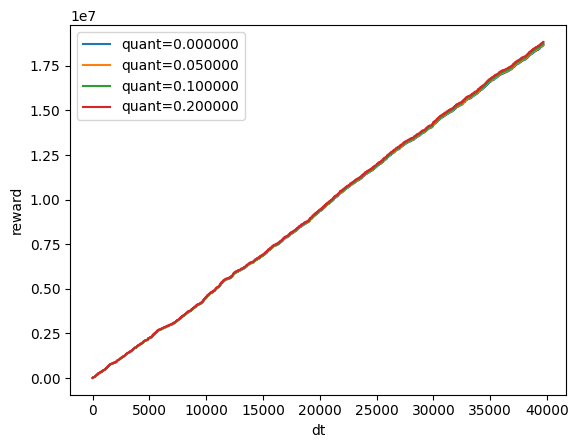

{'quant_0.000000': 369130124582.0, 'quant_0.050000': 370045625767.6626, 'quant_0.100000': 370961126953.3251, 'quant_0.200000': 372792129324.65027}
272.6206155080719
reward_total:  0.1518 fail_action:  0.8482 same_reward:  0.8066 reward_less:  0.0853 reward_lar:  0.1081 possi_lar:  0.1617 possi_small:  0.1011 same_fail  0.7371


(None, None)

In [48]:
eval(dtl_test,agent,device)